In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

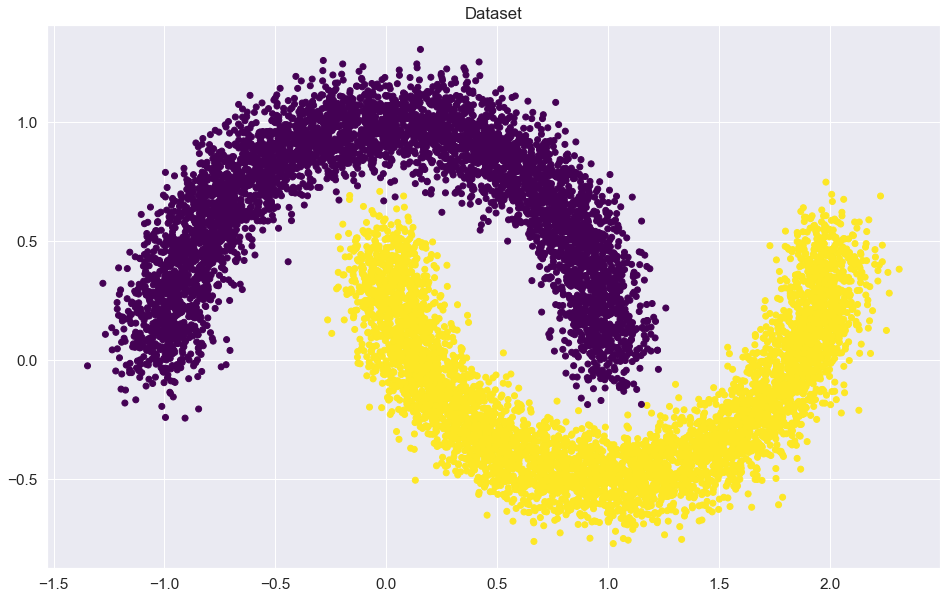

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.tensor(X_train, dtype=torch.float, requires_grad=True)
y_train_t = torch.tensor(y_train, dtype=torch.float, requires_grad=True)
X_val_t = torch.tensor(X_val, dtype=torch.float, requires_grad=True)
y_val_t = torch.tensor(y_val, dtype=torch.float, requires_grad=True)

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта.
Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта.
Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$.
Этот выход как правило называют "логитами" (logits).
Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше,
чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$.
Такой класс функций называется сигмоидой. Чаще всего в качестве сигмоиды берут
$$\sigma(x) = \frac{1}{1 + e^{-x}}.$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели.
Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено).
Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features, requires_grad=True))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features, requires_grad=True))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [9]:
print(list(linear_regression.parameters()))

[Parameter containing:
tensor([[-1.6920],
        [ 1.2015]], requires_grad=True), Parameter containing:
tensor([0.3433], requires_grad=True)]


### Задание. Реализация цикла обучения

In [10]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp, y_batch.unsqueeze(1))
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = linear_regression(X_batch)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if it % 500000 == 0:
            print(f"Iteration: {it + epoch * len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.234375
Iteration: 7500
Batch accuracy: 0.25
Iteration: 15000
Batch accuracy: 0.4921875
Iteration: 22500
Batch accuracy: 0.84375
Iteration: 30000
Batch accuracy: 0.8515625
Iteration: 37500
Batch accuracy: 0.8671875
Iteration: 45000
Batch accuracy: 0.859375
Iteration: 52500
Batch accuracy: 0.859375
Iteration: 60000
Batch accuracy: 0.859375
Iteration: 67500
Batch accuracy: 0.8671875
Iteration: 75000
Batch accuracy: 0.8671875
Iteration: 82500
Batch accuracy: 0.8671875
Iteration: 90000
Batch accuracy: 0.859375
Iteration: 97500
Batch accuracy: 0.859375
Iteration: 105000
Batch accuracy: 0.8515625
Iteration: 112500
Batch accuracy: 0.859375

Iteration: 112547.Convergence. Stopping iterations.


**Вопрос 2.**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ: 112547**

### Визуализируем результаты

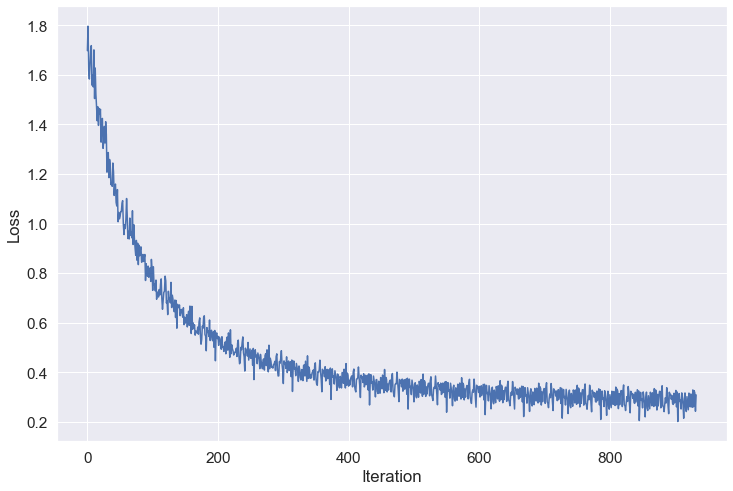

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

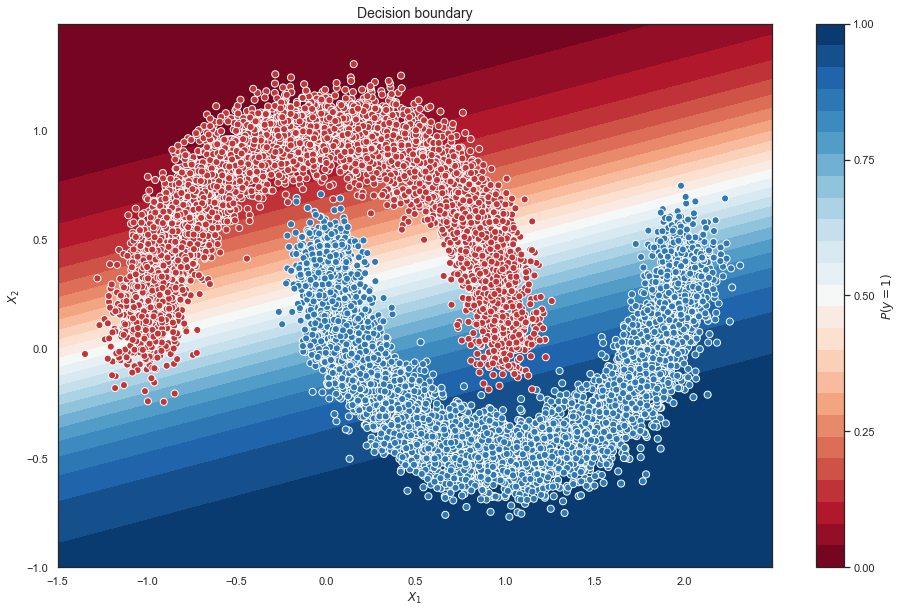

In [12]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:, 0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [13]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = (model(x_batch) > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.detach().numpy().flatten()))
    return predictions.flatten()

In [14]:
from sklearn.metrics import accuracy_score

predictions = predict(val_dataloader, linear_regression)

print(accuracy_score(y_val_t.detach().numpy(), predictions))

0.8928


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ: 0.894**

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [15]:
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

device = "cuda" if torch.cuda.is_available() else "cpu"

# install for train and test
root = './'
train_dataset = MNIST(root, train=True, transform=data_tfs, download=True)
val_dataset = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=128, pin_memory=True)
valid_dataloader = DataLoader(val_dataset, batch_size=128, pin_memory=True)

C:\Users\peter\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [16]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [17]:
activation = nn.ELU

model_first = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 10),
    nn.Softmax()
)

In [18]:
from torch.nn import CrossEntropyLoss

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.

```
python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.


In [19]:
def general(model):
    model.to(device)
    criterion = CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        epoch_correct = 0
        epoch_all = 0
        for k, dataloader in loaders.items():
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                else:
                    model.eval()

                flattened_input = torch.flatten(x_batch, start_dim=1).to(device)

                outp = model(flattened_input).to(device)
                preds = outp.argmax(-1).to(device)

                correct = (preds == y_batch)

                all = len(y_batch)

                for i in range(len(y_batch)):
                    epoch_correct += int(correct[i].item())

                epoch_all += all

                if k == "train":
                    loss = criterion(outp, y_batch).to(device)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch + 1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
            accuracy[k].append(epoch_correct / epoch_all)

    return accuracy


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy.
Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [20]:
elu_accuracy = general(model_first)["valid"]

C:\Users\peter\anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1
Loader: train. Accuracy: 0.8445333333333334
Loader: valid. Accuracy: 0.8531428571428571
Epoch: 2
Loader: train. Accuracy: 0.9098166666666667
Loader: valid. Accuracy: 0.9113857142857142
Epoch: 3
Loader: train. Accuracy: 0.92635
Loader: valid. Accuracy: 0.9265
Epoch: 4
Loader: train. Accuracy: 0.9394
Loader: valid. Accuracy: 0.9396857142857142
Epoch: 5
Loader: train. Accuracy: 0.9481166666666667
Loader: valid. Accuracy: 0.9476571428571429
Epoch: 6
Loader: train. Accuracy: 0.9549333333333333
Loader: valid. Accuracy: 0.9545857142857143
Epoch: 7
Loader: train. Accuracy: 0.96095
Loader: valid. Accuracy: 0.9604
Epoch: 8
Loader: train. Accuracy: 0.96465
Loader: valid. Accuracy: 0.9637285714285714
Epoch: 9
Loader: train. Accuracy: 0.9683333333333334
Loader: valid. Accuracy: 0.9671285714285714
Epoch: 10
Loader: train. Accuracy: 0.9704
Loader: valid. Accuracy: 0.9688142857142857


In [21]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    inner_model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        activation(),
        nn.Linear(128, 10),
        nn.Softmax()
    )

    return general(inner_model)['valid']

In [22]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8358333333333333
Loader: valid. Accuracy: 0.8455285714285714
Epoch: 2
Loader: train. Accuracy: 0.9018833333333334
Loader: valid. Accuracy: 0.9025714285714286
Epoch: 3
Loader: train. Accuracy: 0.9058166666666667
Loader: valid. Accuracy: 0.9063571428571429
Epoch: 4
Loader: train. Accuracy: 0.90995
Loader: valid. Accuracy: 0.9095
Epoch: 5
Loader: train. Accuracy: 0.9124333333333333
Loader: valid. Accuracy: 0.9116428571428571
Epoch: 6
Loader: train. Accuracy: 0.9150333333333334
Loader: valid. Accuracy: 0.9141857142857143
Epoch: 7
Loader: train. Accuracy: 0.9149666666666667
Loader: valid. Accuracy: 0.9150857142857143
Epoch: 8
Loader: train. Accuracy: 0.9153333333333333
Loader: valid. Accuracy: 0.9149428571428572
Epoch: 9
Loader: train. Accuracy: 0.9179
Loader: valid. Accuracy: 0.9177428571428572
Epoch: 10
Loader: train. Accuracy: 0.9162833333333333
Loader: valid. Accuracy: 0.9164285714285715
Epoch: 1
Loader: train. Accuracy: 0.7829
Loader: valid. Accuracy

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

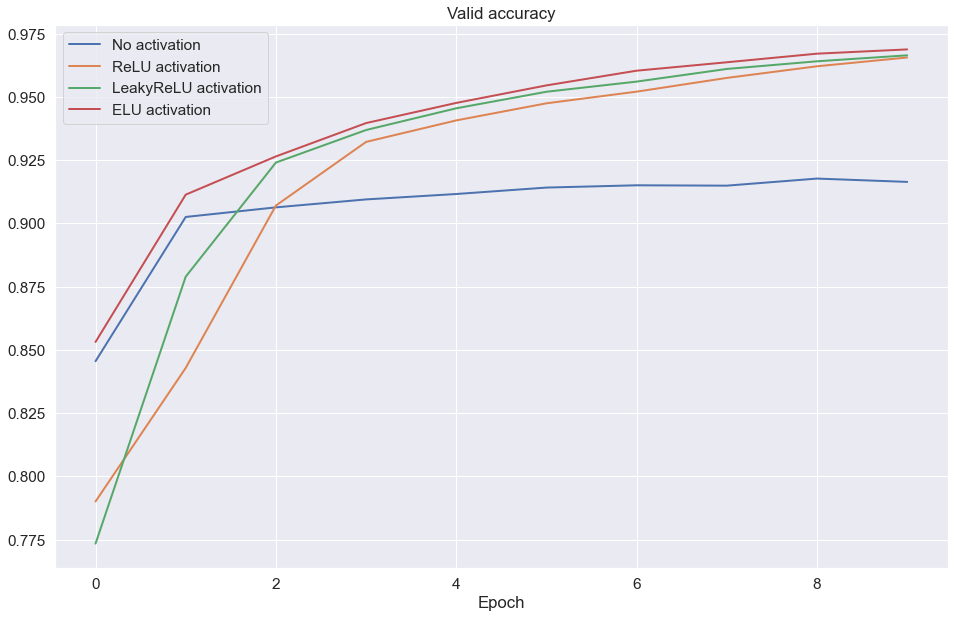

In [23]:
sns.set(style="darkgrid", font_scale=1.4)

max_epochs=10
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

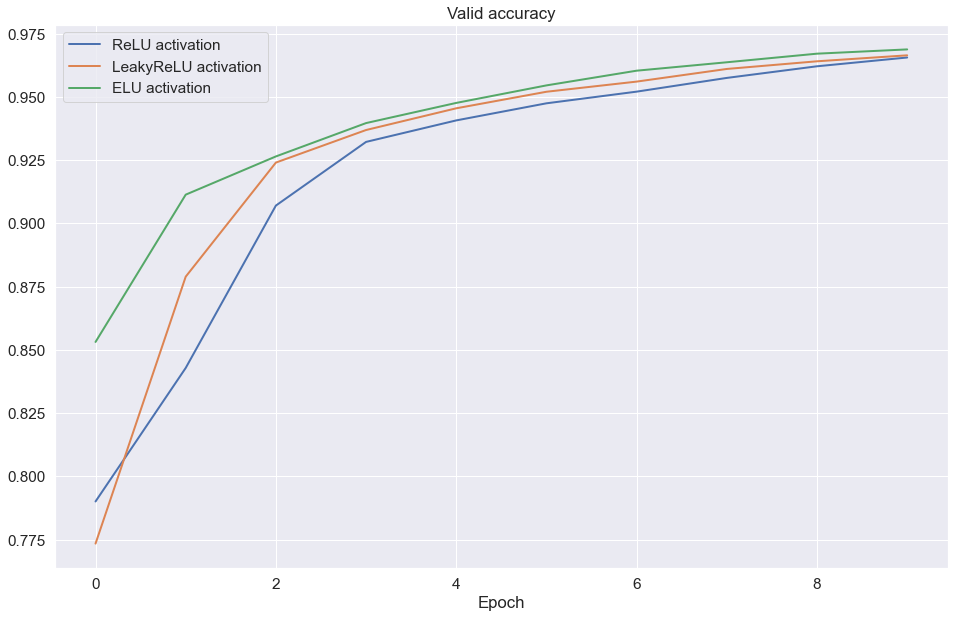

In [24]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ: ELU**

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

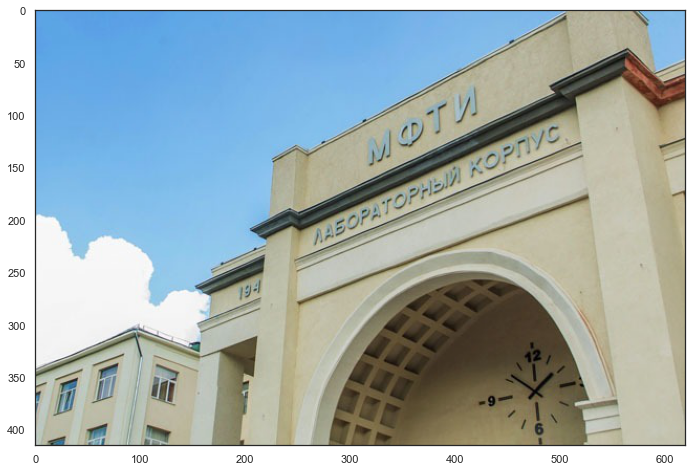

In [25]:
import cv2

sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [26]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, -1, 0],
    [0, 2, 0],
    [0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


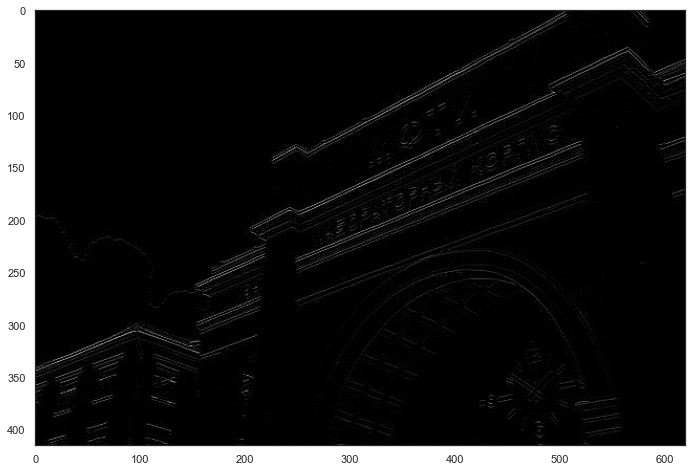

In [27]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ: ЕДАВБГ**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [60]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.pool1 =  nn.MaxPool2d(2, stride=2)
        self.conv2 =  nn.Conv2d(6, 16, 5)
        self.pool2 =  nn.MaxPool2d(2)
        self.fc1 =  nn.Flatten()
        self.fc2 =  nn.Linear(400, 120)
        self.fc3 =  nn.Linear(120, 84)
        self.fc4 =  nn.Linear(84, 10)

    def forward(self, x):
        x =  F.relu(self.pool1(self.conv1(x)))
        x =  F.relu(self.pool2(self.conv2(x)))
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.softmax(self.fc4(x))

In [61]:
import torch.nn.functional as F

new_model = LeNet().to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(new_model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [62]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                new_model.train()
                optimizer.zero_grad()
            else:
                new_model.eval()

            outp = new_model(x_batch).to(device)
            preds = outp.argmax(-1).to(device)

            correct = (preds == y_batch)

            all = len(y_batch)

            for i in range(len(y_batch)):
                epoch_correct += int(correct[i].item())

            epoch_all += all

            if k == "train":
                loss = criterion(outp, y_batch).to(device)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch + 1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
        accuracy[k].append(epoch_correct / epoch_all)

C:\Users\peter\AppData\Local\Temp/ipykernel_13096/1722125216.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc4(x))


Epoch: 1
Loader: train. Accuracy: 0.7544333333333333
Loader: valid. Accuracy: 0.7816428571428572
Epoch: 2
Loader: train. Accuracy: 0.95345
Loader: valid. Accuracy: 0.9555857142857143
Epoch: 3
Loader: train. Accuracy: 0.9684166666666667
Loader: valid. Accuracy: 0.9697428571428571
Epoch: 4
Loader: train. Accuracy: 0.9744166666666667
Loader: valid. Accuracy: 0.9754571428571429
Epoch: 5
Loader: train. Accuracy: 0.9788166666666667
Loader: valid. Accuracy: 0.9788857142857142
Epoch: 6
Loader: train. Accuracy: 0.9799833333333333
Loader: valid. Accuracy: 0.9805
Epoch: 7
Loader: train. Accuracy: 0.9834833333333334
Loader: valid. Accuracy: 0.9833428571428572
Epoch: 8
Loader: train. Accuracy: 0.9847666666666667
Loader: valid. Accuracy: 0.9847
Epoch: 9
Loader: train. Accuracy: 0.98625
Loader: valid. Accuracy: 0.9862285714285715
Epoch: 10
Loader: train. Accuracy: 0.9874333333333334
Loader: valid. Accuracy: 0.9869142857142857


In [63]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

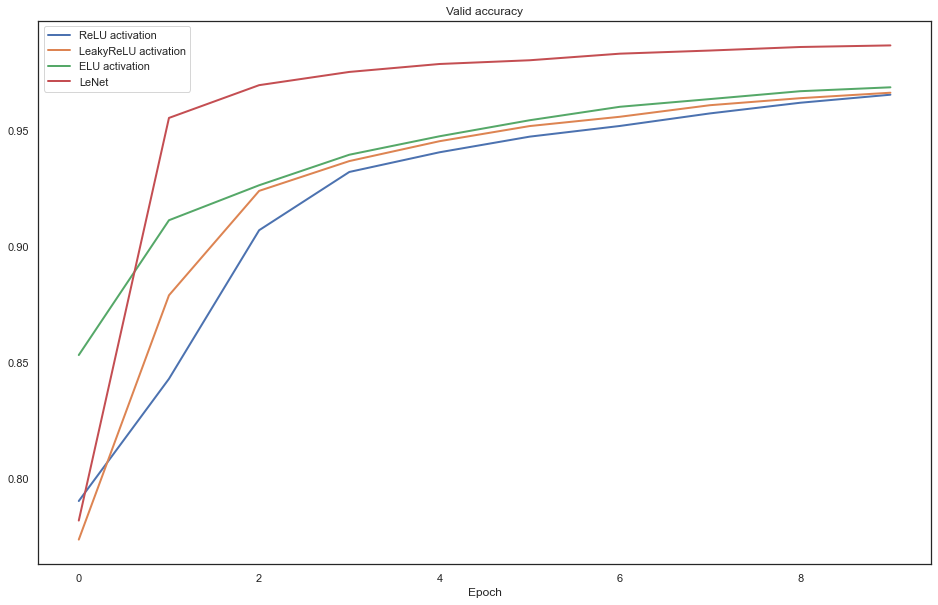

In [64]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ: 0.99**